# Call Data from Clinicaltrial.gov API

In [3]:
# Import libraries
import requests
import json
import os
import datetime
import re
import time
import warnings

from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import random
import shutil
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from imblearn.metrics import specificity_score, sensitivity_score
import nltk
from nltk.classify import NaiveBayesClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
from sklearn.model_selection import cross_val_score, cross_val_predict

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from wordcloud import WordCloud

import en_core_web_sm
nlp = en_core_web_sm.load()
# Download necessary NLTK data
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('stopwords')


# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define figure parameters (feel free to change)
custom_palette = {'FEMALE': 'hotpink', 'MALE': 'lightblue'} 
sns.set_style("darkgrid")
plt.rcParams.update({'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

### Do a Test Call to API to check for bugs

In [4]:
# Define the base URL for the API
base_url = "https://clinicaltrials.gov/api/v2/studies"

# Define the query parameters and desired fields
params = {
    'format': 'json',
    'postFilter.overallStatus': 'COMPLETED',
    'postFilter.advanced': '(AREA[StudyType]INTERVENTIONAL OR OBSERVATIONAL) AND (AREA[Sex]MALE OR AREA[Sex]FEMALE)',
    'fields': 'NCTId|Condition|StartDate|PrimaryCompletionDate|BriefSummary|EnrollmentCount|Sex|MinimumAge|MaximumAge',
    'pageSize': 3  # Limit to 3 records for testing
}

# Function to make the API call
def fetch_clinical_trials(params):
    try:
        response = requests.get(base_url, params=params, headers={"accept": "application/json"})
        # Print the final URL to debug any issues with the query parameters
        print(f"Request URL: {response.url}")
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Fetch the data and print it to test the connection
data = fetch_clinical_trials(params)

# Check if data was retrieved successfully
if data:
    # Print the JSON data
    print(json.dumps(data, indent=2))
else:
    print("No data retrieved or error occurred.")


Request URL: https://clinicaltrials.gov/api/v2/studies?format=json&postFilter.overallStatus=COMPLETED&postFilter.advanced=%28AREA%5BStudyType%5DINTERVENTIONAL+OR+OBSERVATIONAL%29+AND+%28AREA%5BSex%5DMALE+OR+AREA%5BSex%5DFEMALE%29&fields=NCTId%7CCondition%7CStartDate%7CPrimaryCompletionDate%7CBriefSummary%7CEnrollmentCount%7CSex%7CMinimumAge%7CMaximumAge&pageSize=3
{
  "studies": [
    {
      "protocolSection": {
        "identificationModule": {
          "nctId": "NCT01962324"
        },
        "statusModule": {
          "startDateStruct": {
            "date": "2015-03"
          },
          "primaryCompletionDateStruct": {
            "date": "2023-05-09"
          }
        },
        "descriptionModule": {
          "briefSummary": "A single arm phase 2 study to study the outcome of dose-escalation with simultaneous integrated boost to intraprostatic lesion and positive lymph nodes. Prostate cancer patients with high risk of lymph node metastasis or oligo positive nodes in tru

## Run full call to API

In [5]:
# Define the base URL for the API
base_url = "https://clinicaltrials.gov/api/v2/studies"

# Define the query parameters and desired fields
params = {
    'format': 'json',
    'postFilter.overallStatus': 'COMPLETED',
    'postFilter.advanced': '(AREA[StudyType]INTERVENTIONAL OR OBSERVATIONAL)',
    'fields': 'NCTId|Condition|StartDate|PrimaryCompletionDate|BriefSummary|EnrollmentCount|Sex|MinimumAge|MaximumAge',
    'pageSize': 1000  # Number of records to fetch per request
}

# Function to make the API call
def fetch_clinical_trials(params):
    try:
        response = requests.get(base_url, params=params, headers={"accept": "application/json"})
        # Print the final URL to debug any issues with the query parameters
        #print(f"Request URL: {response.url}")
        # Check if the request was successful
        if response.status_code == 200:
            print("API call successful")
            return response.json()
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Function to extract relevant data from the API response
def extract_study_data(study):
    protocol_section = study.get('protocolSection', {})
    identification_module = protocol_section.get('identificationModule', {})
    status_module = protocol_section.get('statusModule', {})
    description_module = protocol_section.get('descriptionModule', {})
    conditions_module = protocol_section.get('conditionsModule', {})
    design_module = protocol_section.get('designModule', {})
    eligibility_module = protocol_section.get('eligibilityModule', {})

    # Exclude records where sex or brief summary is not available
    if 'sex' not in eligibility_module or 'briefSummary' not in description_module:
        return None

    return {
        'NCTId': identification_module.get('nctId', 'N/A'),
        'Condition': conditions_module.get('conditions', ['N/A']),
        'StartDate': status_module.get('startDateStruct', {}).get('date', 'N/A'),
        'PrimaryCompletionDate': status_module.get('primaryCompletionDateStruct', {}).get('date', 'N/A'),
        'BriefSummary': description_module.get('briefSummary', 'N/A'),
        'EnrollmentCount': design_module.get('enrollmentInfo', {}).get('count', 'N/A'),
        'Sex': eligibility_module.get('sex', 'N/A'),
        'MinimumAge': eligibility_module.get('minimumAge', 'N/A'),
        'MaximumAge': eligibility_module.get('maximumAge', 'N/A')
    }

# Fetch and process the data with a delay between requests and avoid duplicates
def fetch_and_process_data(params, max_requests):  # Increase max_requests for more data retrieval
    all_extracted_data = []
    seen_nct_ids = set()
    next_page_token = None

    for _ in range(max_requests):
        if next_page_token:
            params['pageToken'] = next_page_token

        data = fetch_clinical_trials(params)
        if data:
            studies = data.get('studies', [])
            next_page_token = data.get('nextPageToken', None)

            print(f"Number of studies fetched: {len(studies)}")  # Debugging statement
            for study in studies:
                nct_id = study.get('protocolSection', {}).get('identificationModule', {}).get('nctId')
                if nct_id and nct_id not in seen_nct_ids:
                    seen_nct_ids.add(nct_id)
                    extracted_data = extract_study_data(study)
                    all_extracted_data.append(extracted_data)
                    #print(json.dumps(extracted_data, indent=2))  # Debugging statement
                else:
                    print(f"Duplicate or missing NCTId: {nct_id}")

            if not next_page_token:
                break  # No more pages to fetch

        # Pause the execution for a short, random period of time to avoid overwhelming the server
        time.sleep(5 + 10 * random.random())
    
    return all_extracted_data

# Fetch data for random sample of MALE or FEMALE studies
random_sample_params = params.copy()
random_sample_params['postFilter.advanced'] += ' AND (AREA[Sex]MALE OR AREA[Sex]FEMALE)'
random_sample_studies = fetch_and_process_data(random_sample_params, max_requests=15)

# Combine both sets of data
all_data = random_sample_studies 

print("Data fetching and processing complete.")

API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
Data fetching and processing complete.


## Save Raw API Data as .csv and .json

In [6]:
# Convert the extracted data to a DataFrame
all_df = pd.DataFrame(all_data)

# Create a new folder called "data_files"
os.makedirs("data_files", exist_ok=True)

# Save DataFrame to a CSV file in the "data_files" folder
all_df.to_csv(os.path.join("data_files", "clinical_trials.csv"), index=False)

# Save the data to a JSON file in the "data_files" folder
with open(os.path.join("data_files", "clinical_trials.json"), 'w') as outfile:
    json.dump(all_data, outfile, indent=2)

# Loading in data from saved file

### Read in .csv file of data 

In [45]:
all_df = pd.read_csv(r"data_files/clinical_trials.csv")

In [46]:
# Dataframe shape
all_df.shape

(15000, 9)

In [47]:
# Display the DataFrame
all_df.head(), all_df.tail()

(         NCTId                                        Condition   StartDate  \
 0  NCT01962324  ['Prostatic Neoplasms', 'Lymphatic Metastasis']     2015-03   
 1  NCT03198624            ['Safety Issues', 'Pharmacokinetics']  2017-05-16   
 2  NCT01051024                    ['Polycystic Ovary Syndrome']     2009-11   
 3  NCT00183924                      ['Prostate Adenocarcinoma']     2001-03   
 4  NCT00079924                  ['Postmenopausal Osteoporosis']     2004-11   
 
   PrimaryCompletionDate                                       BriefSummary  \
 0            2023-05-09  A single arm phase 2 study to study the outcom...   
 1            2017-08-20  This is a single and multiple dose, parallel g...   
 2               2011-04  The purpose of this study is to assess the eff...   
 3               2006-07  This study is for patients with prostate cance...   
 4                   NaN  Effects of Teriparatide in Postmenopausal Wome...   
 
    EnrollmentCount     Sex MinimumAge Max

In [48]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NCTId                  15000 non-null  object 
 1   Condition              15000 non-null  object 
 2   StartDate              14885 non-null  object 
 3   PrimaryCompletionDate  14325 non-null  object 
 4   BriefSummary           15000 non-null  object 
 5   EnrollmentCount        14766 non-null  float64
 6   Sex                    15000 non-null  object 
 7   MinimumAge             14141 non-null  object 
 8   MaximumAge             9856 non-null   object 
dtypes: float64(1), object(8)
memory usage: 1.0+ MB


# Preprocess All Data + EDA
    * Examine and handle missing values
    * Fix column datatypes
    * Feature creation

### Examine and Handle Missing Values

First handle missing values within the dataframe in preparation for plotting. 

In [49]:
# Count missing values (NaN) in each column
na_counts = all_df.isna().sum()
total_records = len(all_df)
percentage_na = (na_counts / total_records)

# Generate DataFrame from the counts and percentages
na_counts_df = pd.DataFrame({'Missing Count': na_counts, 'Missing Proportion': percentage_na})

# Reset index & rename the index column
na_counts_df.reset_index(inplace=True)
na_counts_df.rename(columns={'index': 'Column'}, inplace=True)

print("DataFrame with counts and percentages of missing (NaN) values:")
print(tabulate(na_counts_df, headers='keys', tablefmt='grid'))

DataFrame with counts and percentages of missing (NaN) values:
+----+-----------------------+-----------------+----------------------+
|    | Column                |   Missing Count |   Missing Proportion |
+====+=======================+=================+======================+
|  0 | NCTId                 |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  1 | Condition             |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  2 | StartDate             |             115 |           0.00766667 |
+----+-----------------------+-----------------+----------------------+
|  3 | PrimaryCompletionDate |             675 |           0.045      |
+----+-----------------------+-----------------+----------------------+
|  4 | BriefSummary          |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|

A new df "no_nans" was created in order to do EDA - this is to seperate it from all the preprocessing step when splitting the data into train and test dataframes.

In [50]:
# Missing values to null for now (simplifies type conversions & plotting)
def na_to_null(df, column):
    df[column] = df[column].replace('N/A', np.nan)
    return df

no_nans = na_to_null(all_df, ['PrimaryCompletionDate', 'StartDate','EnrollmentCount','MinimumAge', 'MaximumAge'])

### Feature Clean-up, Feature Creation

New columns "MinimumAgeYrs" and "MaximumAgeYrs" are created to change all the values that are less than a year to 0.

In [51]:
# Extract years from age feature
def extract_years(age_feature):
    # Check if the input value is already numeric
    if isinstance(age_feature, (int, float)):
        return age_feature
    # If not numeric, split text
    parts = age_feature.split()
    # If unit is Year or Years, return number before the unit
    if parts[1] == 'Years' or parts[1] == 'Year':
        return int(parts[0])
    # Else return 0 years (anything other than year is less than a year (weeks, months, etc))
    return 0

#convert age features to numerical
no_nans['MinimumAgeYrs'] = no_nans['MinimumAge'].apply(extract_years)
no_nans['MaximumAgeYrs'] = no_nans['MaximumAge'].apply(extract_years)

# Convert StartDate PrimaryCompletionDate column to date type
no_nans['StartDate'] = pd.to_datetime(no_nans['StartDate'], errors='coerce')
no_nans['PrimaryCompletionDate'] = pd.to_datetime(no_nans['PrimaryCompletionDate'], errors='coerce')

# Generate Year and Month columns 
no_nans['StartYear'] = no_nans['StartDate'].dt.year
no_nans['StartMonth'] = no_nans['StartDate'].dt.month
no_nans['StartDecade'] = (no_nans['StartYear'] // 10) * 10

# Generate Column for Number of Conditions
no_nans['ConditionCount'] = no_nans['Condition'].apply(lambda x: len(x.split(',')))

# Generate Column for study Duration
no_nans['Duration'] = (no_nans['PrimaryCompletionDate'] - no_nans['StartDate']).dt.days
no_nans['DurationYrsRounded'] = (no_nans['Duration'] / 365).round(2)

In [52]:
# Combine "condition" description with "brief summary" description
no_nans['all_text'] = no_nans['Condition']+" "+no_nans['BriefSummary']

In [53]:
no_nans['all_text'].head()

0    ['Prostatic Neoplasms', 'Lymphatic Metastasis'...
1    ['Safety Issues', 'Pharmacokinetics'] This is ...
2    ['Polycystic Ovary Syndrome'] The purpose of t...
3    ['Prostate Adenocarcinoma'] This study is for ...
4    ['Postmenopausal Osteoporosis'] Effects of Ter...
Name: all_text, dtype: object

# EDA of Data Other than Brief Summary

Let's first see how many different studies there are.

In [54]:
no_nans['Condition'].value_counts()

Condition
['Healthy']                                              870
['Breast Cancer']                                        676
['Prostate Cancer']                                      537
['Infertility']                                          167
['Healthy Volunteers']                                   151
                                                        ... 
['Uncomplicated Urinary Tract Infection', 'Cystitis']      1
['Laparoscopic Gynecological Surgery']                     1
['Endometriosis', 'Dysmenorrhea']                          1
['Prediabetes', 'Obesity']                                 1
['Insulin Resistance', 'Satiety']                          1
Name: count, Length: 7435, dtype: int64

There are 7,417 different conditions that a person can possibly be in this dataframe. Some specified conditions are very vague and do not specify a particular disease like "healthy," "infertility," and "healthy volunteers" which could refer to a lot of different aspects of human health. 

In [55]:
# Gender stats - we are biased towards female-only studies
no_nans['Sex'].value_counts()

Sex
FEMALE    9511
MALE      5489
Name: count, dtype: int64

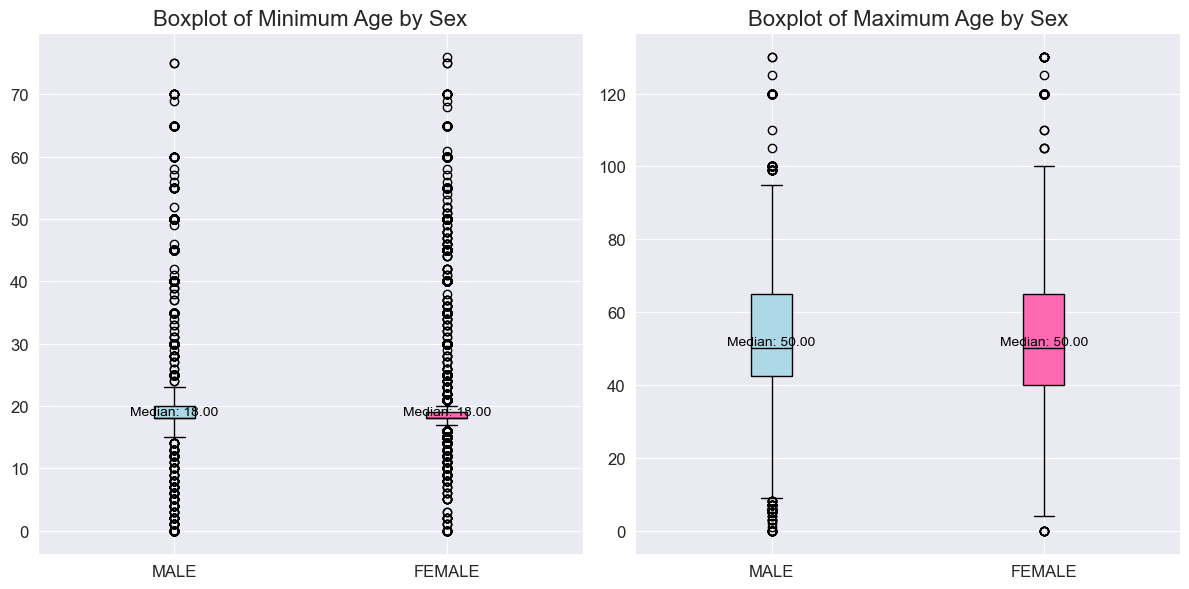

In [56]:
# Age stats by sex - age distribution is the same for both male and female
import matplotlib.pyplot as plt

def plot_boxplot(data, column, ax, title, custom_palette):
    # Filter data by sex
    data_male = data[data['Sex'] == 'MALE'][column].dropna()
    data_female = data[data['Sex'] == 'FEMALE'][column].dropna()
    
    # Plot boxplots
    male_boxes = ax.boxplot(data_male, positions=[1], patch_artist=True, medianprops=dict(color='black'), boxprops=dict(facecolor=custom_palette['MALE']))
    female_boxes = ax.boxplot(data_female, positions=[2], patch_artist=True, medianprops=dict(color='black'), boxprops=dict(facecolor=custom_palette['FEMALE']))
    
    # Add labels and title
    ax.set_title(title)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['MALE', 'FEMALE'])
    
    # Annotate median values for male and female data
    male_median = male_boxes['medians'][0].get_ydata()[0]
    ax.annotate(f'Median: {male_median:.2f}', xy=(1, male_median), xytext=(1, male_median + 0.1), ha='center', va='bottom', fontsize=10, color='black')
    
    female_median = female_boxes['medians'][0].get_ydata()[0]
    ax.annotate(f'Median: {female_median:.2f}', xy=(2, female_median), xytext=(2, female_median + 0.1), ha='center', va='bottom', fontsize=10, color='black')

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define palette
custom_palette = {'FEMALE': 'hotpink', 'MALE': 'lightblue'} 

# Boxplot for MinimumAgeYrs
plot_boxplot(all_df, 'MinimumAgeYrs', axes[0], 'Boxplot of Minimum Age by Sex', custom_palette)

# Boxplot for MaximumAgeYrs
plot_boxplot(all_df, 'MaximumAgeYrs', axes[1], 'Boxplot of Maximum Age by Sex', custom_palette)

# Show plot
plt.tight_layout()
plt.show()

The median minimum and maximum age is similar for both male and female.

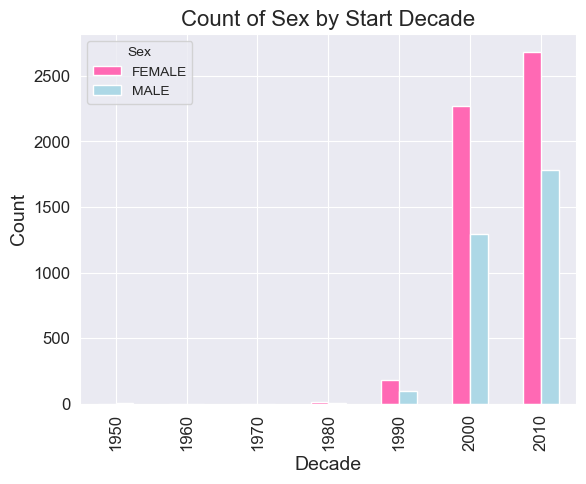

In [57]:
# Date stats by sex

#Could also do by year if desired
counts = no_nans.groupby(['StartDecade', 'Sex']).size().unstack(fill_value=0)

counts.index = counts.index.astype(int)

ax = counts.plot(kind='bar', stacked=False, color=custom_palette)

# Add labels and title
plt.title('Count of Sex by Start Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Sex')
 
# Show plot
plt.show()

There are very few studies from before the year 2000. In 1980 and every decade after, there are more studies invovling all female participants based on our random sample from the entire registry.

<Figure size 1000x600 with 0 Axes>

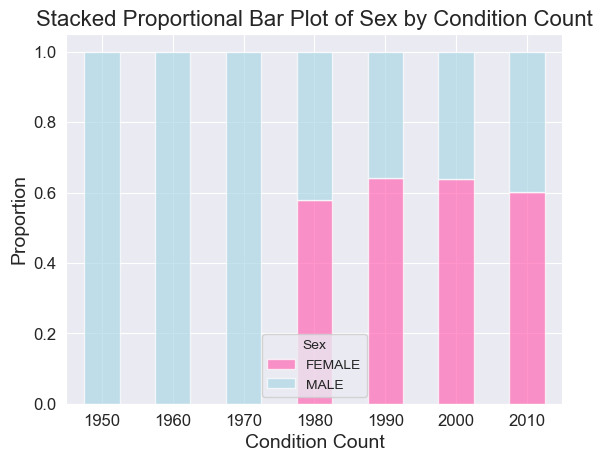

In [58]:
# stacked proportional bar plot
# Calculate proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
plt.figure(figsize=(10, 6))
proportions.plot(kind='bar', stacked=True, color=custom_palette, alpha=0.7)
plt.title('Stacked Proportional Bar Plot of Sex by Condition Count')
plt.xlabel('Condition Count')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Sex')
plt.show()

This figure shows that the proportion of studies containing female participants gradually increased from 1970 until 1990. It leveled out every year after that, at about 0.65.

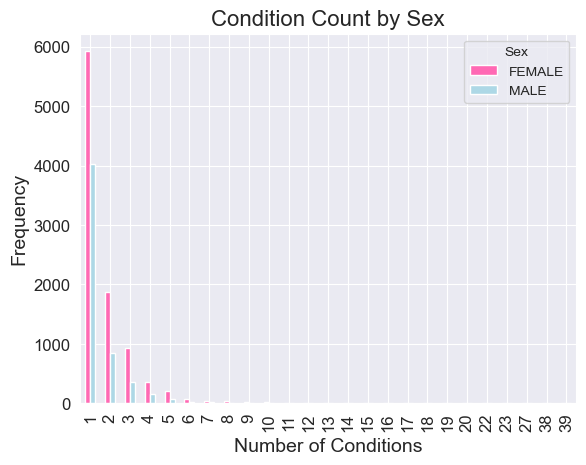

In [59]:
# Number of conditions by sex
counts = no_nans.groupby(['ConditionCount', 'Sex']).size().unstack(fill_value=0)

counts.index = counts.index.astype(int)

ax = counts.plot(kind='bar', stacked=False, color=custom_palette)

# Add labels and title
plt.title('Condition Count by Sex')
plt.xlabel('Number of Conditions')
plt.ylabel('Frequency')
 
# Show plot
plt.show()


Most of the studies involve one condition. 

<Figure size 1000x600 with 0 Axes>

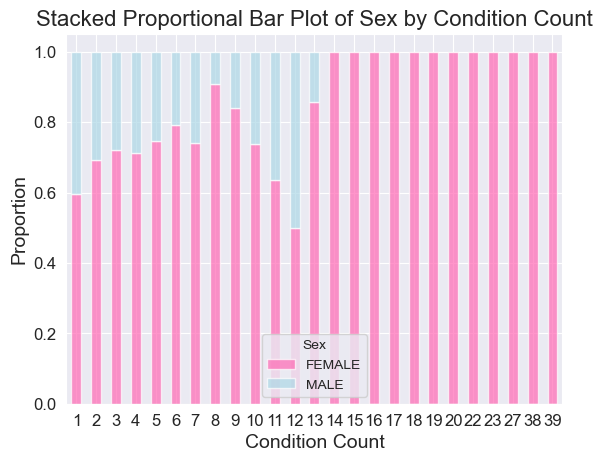

In [60]:
# stacked proportional bar plot
# Calculate proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
plt.figure(figsize=(10, 6))
proportions.plot(kind='bar', stacked=True, color=custom_palette, alpha=0.7)
plt.title('Stacked Proportional Bar Plot of Sex by Condition Count')
plt.xlabel('Condition Count')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Sex')
plt.show()

All studies with more than 13 conditions involve female participants.

In [61]:
# Enrollment Numbers by Sex

# Get descriptive statistics
enrollment_stats = no_nans.groupby('Sex')['EnrollmentCount'].describe()

# Round statistics to whole numbers
rounded_enrollment_stats = enrollment_stats.astype(int)

# Display table with title
print("Enrollment Statistics by Sex:\n")
print(tabulate(rounded_enrollment_stats, headers=rounded_enrollment_stats.columns, tablefmt='pretty'))

Enrollment Statistics by Sex:

+--------+-------+------+-------+-----+-----+-----+-----+--------+
|        | count | mean |  std  | min | 25% | 50% | 75% |  max   |
+--------+-------+------+-------+-----+-----+-----+-----+--------+
| FEMALE | 9366  | 870  | 15874 |  0  | 40  | 80  | 200 | 961985 |
|  MALE  | 5400  | 151  | 1853  |  0  | 18  | 33  | 68  | 114035 |
+--------+-------+------+-------+-----+-----+-----+-----+--------+


In [62]:
# Study Duration by Sex (rounded to closest # of years)

# Get descriptive statistics
duration_stats = no_nans.groupby('Sex')['DurationYrsRounded'].describe()

# Round statistics to whole numbers
rounded_duration_stats = round(duration_stats,2)

# Display table with title
print("Study Duration by Sex:\n")
print(tabulate(rounded_duration_stats, headers=rounded_duration_stats.columns, tablefmt='pretty'))

Study Duration by Sex:

+--------+-------+------+------+------+------+------+------+-------+
|        | count | mean | std  | min  | 25%  | 50%  | 75%  |  max  |
+--------+-------+------+------+------+------+------+------+-------+
| FEMALE | 317.0 | 4.16 | 2.84 | 0.19 | 2.25 | 3.45 | 5.29 | 19.01 |
|  MALE  | 160.0 | 4.04 | 3.32 | 0.11 | 1.81 | 3.5  | 5.35 | 26.46 |
+--------+-------+------+------+------+------+------+------+-------+


## Train/Test Split

In [63]:
# Save SexString as a column for investigation/troubleshooting post-mapping
no_nans['SexString'] = no_nans['Sex']
no_nans['Sex'] = no_nans['Sex'].map({'FEMALE': 0, 'MALE': 1})

# Split the DataFrame into features (X) and target variable (y)
y = no_nans['Sex']
X = no_nans.drop(['Sex', 'SexString'],axis = 1)  # Drop target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In order to resample, I can't use smote as we have non-numeric and categorical variables. But, we can manually do it. The X_train and y_train have to be put back together in order to resample.

In [64]:
# Create a synthetic DataFrame
y_train = pd.DataFrame(y_train)
y_train = y_train.rename(columns = {0:'Sex'})
temp_df = pd.concat([X_train, y_train], axis=1)

In [65]:
# Drop values of NaN for brief summaries
temp_df = temp_df.dropna(subset=['BriefSummary'])

In [66]:
# Display class distribution
print("Training Outcome Class distribution:")
print(temp_df['Sex'].value_counts())

Training Outcome Class distribution:
Sex
0    7612
1    4388
Name: count, dtype: int64


## Class Balancing Methods: Subsequent Comparison of Performance Between Both

## Oversampling method

In [67]:
# Separate minority and majority classes

# Male =1, Female = 0
minority_class = temp_df[temp_df['Sex'] == 1]
majority_class = temp_df[temp_df['Sex'] == 0]

# Determine the number of samples in the majority class
majority_count = len(majority_class)

# Sample from the minority class with replacement to match the number of samples in the majority class
minority_resampled = minority_class.sample(n=majority_count, replace=True, random_state=42)

# Combine the resampled minority class with the original majority class
oversampled_df = pd.concat([majority_class, minority_resampled])

# Shuffle the dataframe
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display resampled class distribution
print("\nOesampled class distribution:")
print(oversampled_df['Sex'].value_counts())


Oesampled class distribution:
Sex
1    7612
0    7612
Name: count, dtype: int64


## Undersampling method

In [68]:
# Separate minority and majority classes
minority_class = temp_df[temp_df['Sex'] == 1]
majority_class = temp_df[temp_df['Sex'] == 0]

# Determine the number of samples in the minority class
minority_count = len(minority_class)

# Sample from the majority class without replacement to match the number of samples in the minority class
majority_resampled = majority_class.sample(n=minority_count, replace=False, random_state=42)

# Combine the resampled majority class with the original minority class
resampled_df = pd.concat([minority_class, majority_resampled])

# Shuffle the dataframe
resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display resampled class distribution
print("\nResampled class distribution:")
print(resampled_df['Sex'].value_counts())


Resampled class distribution:
Sex
1    4388
0    4388
Name: count, dtype: int64


# Apply Preprocessing Pipeline to Brief Summary Text Data

* Remove dimorphic terms
* Remove academic stopwords
* Remove generic stopwords
* Tokenize text
* Remove punctuation
* Convert all text to lowercase
* Remove numerical tokens
* Lemmatize tokens
* Remove duplicate tokens

### Lists of Words to Remove

In [69]:
sw = stopwords.words("english")
punctuation = set(punctuation)

# List of dimorphic body parts/experiences and medical/anatomical lemmas 
dimorphic_terms = [
"Penis", "Scrotum", "Testicles","testicular", "Epididymis", "deferens", "Seminal vesicles",
"Prostate", "prostatic", "psa", "Cowpers", "Foreskin", "penile",
"Sperm", "Ejaculation", "Spermatogenesis",
"Erection", "erectile", "Vagina", "vaginal", "Vulva", "Labia", "Clitoris",
"clitoral", "ovarian", "uterine", "cervical", "menstrual",
"Vestibule", "Ovary", "Fallopian", "Uterus", "Cervix", "Bartholins",
"Skenes", "Hymen", "Endometrium", "Myometrium", "Placenta",
"Amniotic", "Umbilical", "Chorion", "Decidua", "Gestation",
"Yolk", "Amnion", "Lochia", "Menstruation", "Period",
"Menarche", "Menopause", "Ovulation", "Dysmenorrhea", "Labor", "Childbirth", "Lactation",
"Breastfeeding", "Pregnancy", "pregnant", "male", "female", "man", "woman", "men", "women", "girl",
"boy", "postmenopausal", "gestational", "polycystic", "contraception", "infant",
"estradiol", "maternal", "placental", "body", "human", "cancer",
"pcos", "endometriosis", "metabolic", "physical", "mother", "father", "son", "daughter",
"sister", "brother", "obstetric", "breast", "baby", "prenatal", "section",
"fetal", "mastectomy", "msm", "labour", "labor", "hemorrhage", "birth",
"newborn", "born", "neonatal", "postpartum"
]

# List of common academic/medical noise terms that don't provide information
academic_stop_words = [
"academic", "group", "study", "research", "blind", "recruit", "design",
"healthy", "subjects", "participants", "purpose", "effects", "clinical",
"trial", "single", "intervention", "patient", "day", "month",
"year", "week", "determine", "test", "volunteer", "investigate", "investigator",
"evaluate", "evaluated", "wa", "ha", "use", "difference", "demonstrate", "reliability",
"usability", "compare", "contrast", "conducted", "aim", "may",
"therapy", "treatment", "risk", "health", "efficacy", "effect",
"rate", "level", "randomize", "randomized", "objective", "outcome",
"primary", "secondary", "compared", "therapy", "treatment", "risk",
"health", "evidence", "background", "with", "without", "adverse",
"consequence", "consequences", "benefit", "form", "care", "using",
"two", "subset", "similarity", "similarities", "similarly", "latter",
"former", "use", "used", "concomitantly", "spontaneous", "responded",
"attendance", "open", "label", "effectiveness", "effective", "whether",
"state", "safety", "tolerability", "phase", "also", "time", "controlled",
"also", "reusable", "overall", "new", "matching", "correlation", "plus",
"addition", "characterize", "pilot", "behavior", "strong", "developed",
"developing", "rationale", "indication", "indicated", "standard",
"standardized", "undergo", "screening", "represents", "screened",
"represented", "representing", "tolerance", "people", "goal",
"structured", "supervised", "placement", "control", "proven",
"following", "followed", "designed", "describe", "described",
"implement", "implemented", "complete", "completed", "estimate",
"estimated", "get", "comparative", "compared", "intervene",
"determined", "tested", "common", "assessed", "assess", "event",
"find", "found", "first", "reducing", "openlabel", "marketed",
"asked", "take", "demonstrated", "conduct", "deliver", "delivered",
"followup", "individualized", "individualised", "prospective",
"currently", "current", "given", "experiment", "looking", "treated",
"looked", "treat", "including", "investigated", "frequently", "frequent",
"related", "relate", "interested", "taking", "conventional", "medical",
"quality", "assessing", "pattern", "additional", "well", "multiple",
"one", "life", "improve", "method", "increase", "symptom", "Do's",
"administration", "different", "mg", "condition", "receive", "received",
"result", "results", "reduce", "associated", "oral", "change", "changed",
"placebo", "dose", "program", "drug", "among", "data", "hypothesis",
"combination", "delivery", "however", "response", "high", "function",
"administered", "type", "blood", "impact", "either", "factor",
"undergoing", "crossover", "tablet", "disorder", "ii", "cell",
"activity", "pharmacokinetic", "low", "measure", "based", "three",
"four", "five", "six", "seven", "eight", "nine", "performance",
"performed", "pk", "main", "primary", "secondary", "efficient",
"preferred", "examined", "examine", "prefer", "tends", "present",
"sample", "help", "treating", "treated", "potential", "stage",
"population", "shown", "daily", "weekly", "annually", "yearly",
"lower", "known", "parameter", "part", "confirmed", "clearly",
"clear", "confirm", "taken", "localized", "cohort", "feasibility",
"analyze", "analyzed", "way", "investigation", "possibly", "possible",
"cause", "comparing", "acceptability", "amount", "document", "include",
"included", "decrease", "decreased", "increase", "increased", "provide",
"provided", "versus", "assessment", "evaluation", "due", "total",
"hypothesize", "hour", "minute", "second", "affect", "effect",
"participant", "ass", "subject", "dos", "ascending", "descending",
"unintended", "intended", "early", "late"
]

# Combine list
extra_sw = dimorphic_terms+academic_stop_words

# Lemmatize lists
extra_sw = [lemmatizer.lemmatize(term.lower()) for term in extra_sw]

# Combine NLTK stopwords with additional stopwords
final_stopwords = set(sw + extra_sw)

### Create Pipeline of Functions

In [70]:
lemmatizer = WordNetLemmatizer()

# Remove stopwords (sw) from text
def remove_stopwords(tokens, sw):
    return [token for token in tokens if token not in sw]

# Split text on whitespace
def tokenize(text):
    return text.split()

# Remove punctuation
def remove_punctuation(text, punct_set=punctuation):
    return "".join([ch for ch in text if ch not in punct_set])

# Remove dimorphic terms
def remove_dimorphic_terms(tokens, terms):
    return [token for token in tokens if token.lower() not in terms]

# Convert all tokens to lowercase
def lowercase_tokens(tokens):
    return [token.lower() for token in tokens]

# Remove numerical tokens
def remove_numerical_tokens(tokens):
    return [token for token in tokens if not token.isdigit()]

# Lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Remove duplicate tokens within a row while preserving order
def remove_duplicate_tokens(tokens):
    return list(OrderedDict.fromkeys(tokens))

def process_text(text, pipeline):
    if pd.isnull(text):  # Check if text is NaN
        return text  # Return NaN without processing
    else:
        for function in pipeline:
            text = function(text)
        return text

# Define the text processing pipeline
summary_pipeline = [
    remove_punctuation,
    tokenize,
    lowercase_tokens,
    remove_numerical_tokens,
    lemmatize_tokens,
    lambda tokens: remove_stopwords(tokens, final_stopwords),
    lambda tokens: remove_dimorphic_terms(tokens, extra_sw),
    remove_duplicate_tokens
]

In [71]:
# Save as new column, ProcessedSummmary for analysis
resampled_df['ProcessedSummary'] = resampled_df['all_text'].apply(lambda x: process_text(x, summary_pipeline))
oversampled_df['ProcessedSummary'] = oversampled_df['all_text'].apply(lambda x: process_text(x, summary_pipeline))

In [72]:
resampled_df.shape, resampled_df['Sex'].value_counts()

((8776, 19),
 Sex
 1    4388
 0    4388
 Name: count, dtype: int64)

### Examine Clean Tokens

In [73]:
resampled_df['ProcessedSummary'].head(10)

0    [genz682452, adult, gzfd00111tdu12766, doubleb...
1    [singleblind, metastatic, adenocarcinoma, dos,...
2    [aromatase, inhibitor, musculoskeletal, surviv...
3    [autonomic, nervous, system, cardiovascular, v...
4    [nonionizing, radiation, radio, frequency, ele...
5        [repeated, dos, azd6280, midazolam, caffeine]
6    [vitamin, deficiency, respiratory, tract, infe...
7    [obese, diabetes, prevention, dpp, meet, clini...
8    [overactive, bladder, addon, solifenacin, pers...
9    [turner, syndrome, hypogonadism, premature, fa...
Name: ProcessedSummary, dtype: object

### Distribution of length of tokens for each study

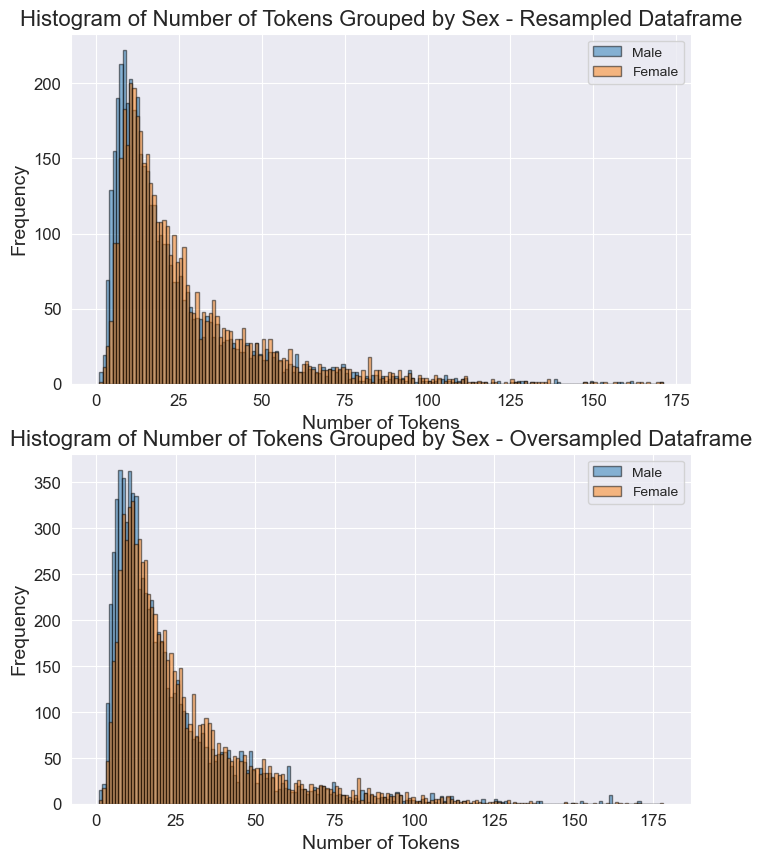

In [74]:
# Distribution of Number of Tokens by Sex
# Count the number of tokens in each list
# Function to count tokens in a list
def count_tokens(token_list):
    if isinstance(token_list, list):
        return len(token_list)
    else:
        return 0  
        
resampled_df['num_tokens'] = resampled_df['ProcessedSummary'].apply(count_tokens)
oversampled_df['num_tokens'] = oversampled_df['ProcessedSummary'].apply(count_tokens)

# Group by 'sex' and plot histogram
male_tokens_resampled = resampled_df[resampled_df['Sex'] == 1]['num_tokens']
female_tokens_resampled = resampled_df[resampled_df['Sex'] == 0]['num_tokens']

male_tokens_oversampled = oversampled_df[oversampled_df['Sex'] == 1]['num_tokens']
female_tokens_oversampled = oversampled_df[oversampled_df['Sex'] == 0]['num_tokens']

plt.figure(figsize=(8, 10))
ax_resampled = plt.subplot(2,1,1)
ax_resampled.hist(male_tokens_resampled, bins=range(1, max(resampled_df['num_tokens']) + 2), alpha=0.5, label='Male', edgecolor='black')
ax_resampled.hist(female_tokens_resampled, bins=range(1, max(resampled_df['num_tokens']) + 2), alpha=0.5, label='Female', edgecolor='black')
ax_resampled.set_xlabel('Number of Tokens')
ax_resampled.set_ylabel('Frequency')
ax_resampled.set_title('Histogram of Number of Tokens Grouped by Sex - Resampled Dataframe')
ax_resampled.legend(loc='upper right')

ax_oversampled = plt.subplot(2,1,2)
ax_oversampled.hist(male_tokens_oversampled, bins=range(1, max(oversampled_df['num_tokens']) + 2), alpha=0.5, label='Male', edgecolor='black')
ax_oversampled.hist(female_tokens_oversampled, bins=range(1, max(oversampled_df['num_tokens']) + 2), alpha=0.5, label='Female', edgecolor='black')
ax_oversampled.set_xlabel('Number of Tokens')
ax_oversampled.set_ylabel('Frequency')
ax_oversampled.set_title('Histogram of Number of Tokens Grouped by Sex - Oversampled Dataframe')
ax_oversampled.legend(loc='upper right')

# Show the plot
plt.show()

Trend appears similar for both the resampled and oversampled dataframe. Males have a higher frequency of lower token counts, hwile female have a higher frequency of greater token counts, which is also reflected in females having more conditions studied in one clinical trial. 

# Descriptive Stats of Text Data

In [75]:
# Function that reads through nested lists of tokens
def new_descriptive_stats(tokens, num_tokens = 5 , verbose=True) :

    # Fill in the correct values here. 
    flat_tokens = [token for sublist in tokens if isinstance(sublist, list) for token in sublist if not isinstance(token, float)]
    total_tokens = len(flat_tokens)  # total number of tokens
    num_tokens = len(flat_tokens) # number of tokens
    num_unique_tokens = len(set(flat_tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens  # lexical diversity
    num_characters = sum(len(token) for token in flat_tokens) # number of characters
    most_common_tokens = Counter(flat_tokens).most_common(num_tokens)[0:16] # most common tokens
   
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    print(f"The fifteen most common tokens are {most_common_tokens} in the data.")      
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

## Female descriptives

Resampled Data

In [76]:
new_descriptive_stats(resampled_df[resampled_df['Sex'] == 0]['ProcessedSummary'])

There are 116089 tokens in the data.
There are 18257 unique tokens in the data.
There are 908332 characters in the data.
The lexical diversity is 0.157 in the data.
The fifteen most common tokens are [('pain', 534), ('disease', 359), ('surgery', 344), ('chemotherapy', 263), ('tumor', 247), ('exercise', 233), ('postoperative', 233), ('complication', 232), ('infection', 228), ('age', 217), ('weight', 212), ('procedure', 212), ('system', 208), ('hospital', 207), ('syndrome', 204), ('management', 203)] in the data.


[116089, 18257, 0.15726726907803495, 908332]

Oversampled Data

In [77]:
new_descriptive_stats(oversampled_df[oversampled_df['Sex'] == 0]['ProcessedSummary'])

There are 201797 tokens in the data.
There are 24646 unique tokens in the data.
There are 1576122 characters in the data.
The lexical diversity is 0.122 in the data.
The fifteen most common tokens are [('pain', 910), ('disease', 643), ('surgery', 613), ('chemotherapy', 433), ('tumor', 421), ('infection', 414), ('exercise', 405), ('postoperative', 403), ('age', 402), ('complication', 382), ('weight', 377), ('syndrome', 373), ('procedure', 368), ('stress', 341), ('cesarean', 341), ('hospital', 335)] in the data.


[201797, 24646, 0.1221326382453654, 1576122]

The oversampled data lower lexical diversity than the resampled data. The fifteen most common words also differ a bit, although the top 5 words remain the same.

## Male descriptives: 

Resampled Data

In [78]:
new_descriptive_stats(resampled_df[resampled_df['Sex'] == 1]['ProcessedSummary'])

There are 101122 tokens in the data.
There are 17796 unique tokens in the data.
There are 791553 characters in the data.
The lexical diversity is 0.176 in the data.
The fifteen most common tokens are [('pharmacokinetics', 552), ('disease', 455), ('dos', 370), ('adult', 317), ('exercise', 295), ('muscle', 280), ('diabetes', 218), ('metabolism', 209), ('bioavailability', 200), ('hormone', 199), ('training', 192), ('pain', 191), ('tumor', 189), ('profile', 187), ('food', 182), ('acute', 179)] in the data.


[101122, 17796, 0.1759854433258836, 791553]

Oversampled Data

In [79]:
new_descriptive_stats(oversampled_df[oversampled_df['Sex'] == 1]['ProcessedSummary'])

There are 176707 tokens in the data.
There are 15754 unique tokens in the data.
There are 1379755 characters in the data.
The lexical diversity is 0.089 in the data.
The fifteen most common tokens are [('pharmacokinetics', 985), ('disease', 761), ('dos', 616), ('adult', 533), ('exercise', 497), ('muscle', 497), ('bioavailability', 377), ('diabetes', 359), ('pain', 355), ('metabolism', 353), ('food', 345), ('hormone', 329), ('tissue', 316), ('tumor', 315), ('system', 309), ('acute', 309)] in the data.


[176707, 15754, 0.08915323105479693, 1379755]

As male is the minority and therefore oversampled class, the oversampled data has a significantly lower lexical diversity than the resampled data (.086, compared to .170).

# Word Clouds of Top Tokens for Male and Female

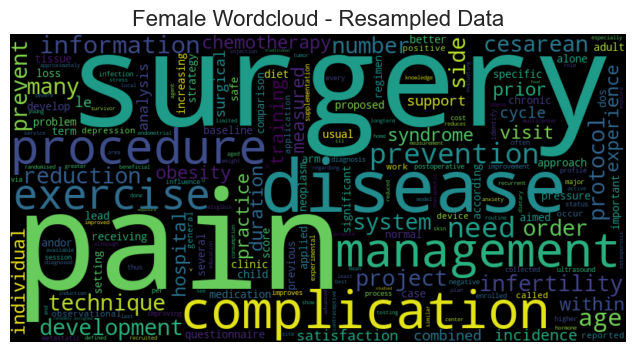

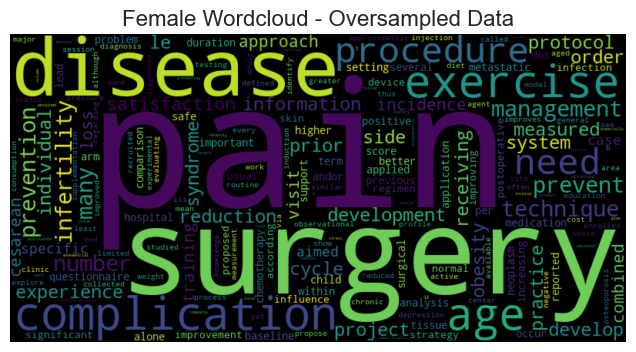

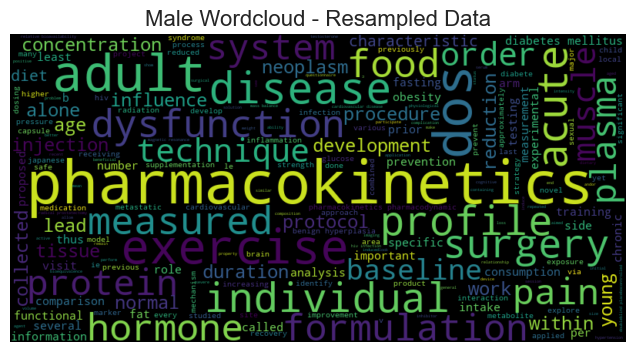

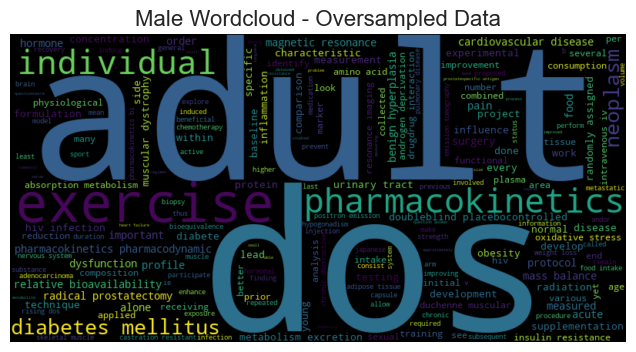

In [80]:
# subset data by gender and sampling method

female_text_resampled = resampled_df[resampled_df['Sex'] == 0]['ProcessedSummary']
female_text_oversampled = oversampled_df[oversampled_df['Sex'] == 0]['ProcessedSummary']
male_text_resampled = resampled_df[resampled_df['Sex'] == 1]['ProcessedSummary']
male_text_oversampled = oversampled_df[oversampled_df['Sex'] == 1]['ProcessedSummary']


def generate_wordcloud(list_of_lists, title=None, width=800, height=400):
    # Flatten the list of lists into a single list of words
    words = [word for sublist in list_of_lists for word in sublist]
    
    # Join the words into a single string
    text = ' '.join(words)
    
    # Create word cloud
    wordcloud = WordCloud(width=width, height=height).generate(text)
    
    # Display the word cloud with title
    plt.figure(figsize=(8, 4))  # Adjust figsize if needed
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    if title:
        plt.title(title)
    
    plt.show()

generate_wordcloud(female_text_resampled, "Female Wordcloud - Resampled Data")
generate_wordcloud(female_text_oversampled, "Female Wordcloud - Oversampled Data")
generate_wordcloud(male_text_resampled, "Male Wordcloud - Resampled Data")
generate_wordcloud(male_text_oversampled, "Male Wordcloud - Oversampled Data")

The female wordclouds look generally similar between resampled and oversampled data. However, the male wordclouds look significantly different, due to 'male' being the minority class, and therefore being oversampled.

# Save Processed Data to Data_files folder

In [81]:
# Save DataFrames to CSV files in the "data_files" folder
resampled_df.to_csv(os.path.join("data_files", "resampled_df.csv"), index=False)
oversampled_df.to_csv(os.path.join("data_files", "oversampled_df.csv"), index=False)
X_test.to_csv(os.path.join("data_files", "X_test.csv"), index=False)
y_test.to_csv(os.path.join("data_files", "y_test.csv"), index=False)

print("DataFrames saved successfully to data_files/")

DataFrames saved successfully to data_files/
